In [18]:
# Import modules
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from torch.utils.data import Subset
import math
import optuna
import numpy as np

In [19]:
def set_device():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    if torch.cuda.is_available():
        print(f'Using device: {device}')
        print(f'GPU: {torch.cuda.get_device_name(0)}')
    else:
        print(f'Using device: {device}')

    return device

In [20]:
def norm_data(name):
    df = pd.read_csv(name)
    ndf = pd.DataFrame()
    range_mm={
        'V': {'min':df['V'].min()*0.8, 'max': df['V'].max()*1.2},
        'E': {'min':df['E'].min()*0.8, 'max': df['E'].max()*1.2},
        'VF': {'min':df['VF'].min()*0.8, 'max': df['VF'].max()*1.2},
        'VA': {'min':df['VA'].min()*0.8, 'max': df['VA'].max()*1.2},
        'VB': {'min':df['VB'].min()*0.8, 'max': df['VB'].max()*1.2},
        'CFLA': {'min':0, 'max': df['CFLA'].max()*1.2},
        'CALA': {'min':0, 'max': df['CALA'].max()*1.2},
        'CFK': {'min':0, 'max': df['CFK'].max()*1.2},
        'CBK': {'min':0, 'max': df['CBK'].max()*1.2},
        'I': {'min':0, 'max': df['I'].max()*1.2},
    }

    ndf['exp'] = df['exp']; ndf['t'] = df['t']

    for col in ['V', 'E', 'VF', 'VA', 'VB', 'CFLA', 'CALA', 'CFK', 'CBK', 'I']:
        if col in range_mm:
            ndf[col] = (df[col] - range_mm[col]['min'])/(range_mm[col]['max'] - range_mm[col]['min'])
        else:
            ndf[col] = df[col]

    # Get the unique experiment numbers in order
    exp_num_list = sorted(ndf['exp'].unique())
    return ndf, exp_num_list

In [21]:
def seq_data(ndf):
    seq = []
    # CBLA, CAK만 제거: 학습 불안정성 때문에
    # 전류(I)는 포함: ground truth로 사용하여 예측 성능 비교
    feature_cols = ['V', 'E', 'VF', 'VA', 'VB', 'CFLA', 'CALA', 'CFK', 'CBK', 'I']
    
    for exp in ndf['exp'].unique():
        exp_data = ndf[ndf['exp'] == exp].sort_values(by='t')
        seq.append(exp_data[feature_cols].values)
    
    return seq

In [22]:
def pad_seq(seq):
    max_len = max([len(seq) for seq in seq])
    seq_len = [len(seq) for seq in seq]
    pad_seq = pad_sequence([torch.tensor(seq) for seq in seq], batch_first=True, padding_value=-1)

    return pad_seq, seq_len, max_len

In [23]:
def gen_dataset(pad_seq, seq_len):
    input_tensor = pad_seq.float()
    seq_len_tensor = torch.tensor(seq_len)
    dataset = TensorDataset(input_tensor, seq_len_tensor)
    return dataset

In [24]:
def dataloaders(dataset, exp_num_list, batch_size=4):
    """
    Split the dataset into train/val/test with 8:1:1 ratio
    
    Args:
        dataset: TensorDataset
        exp_num_list: list of experiment numbers
        batch_size: batch size
        random_state: random seed
        
    Returns:
        tuple: (train_loader, val_loader, test_loader)
    """

    
    # required train experiment numbers
    required_train_exps = [0, 2, 4, 5, 8, 9, 10, 13, 15, 17, 20, 22, 24, 26, 33, 34]
    
    # all experiment numbers
    all_exps = exp_num_list
    total_exps = len(all_exps)
    
    # batch_size
    batch_size = math.ceil(len(dataset)/10)

    # 8:1:1 ratio
    train_count = int(total_exps * 0.8)
    val_count = math.ceil(total_exps * 0.1)
    
    # remaining experiments
    remaining_exps = [exp for exp in all_exps if exp not in required_train_exps]
    
    # number of experiments to add to train
    additional_train_needed = train_count - len(required_train_exps)
    
    if additional_train_needed < 0:
        raise ValueError("The number of required train experiments is greater than the total train set. Please adjust required_train_exps.")
    
    # shuffle remaining experiments
    np.random.shuffle(remaining_exps)
    
    # split remaining experiments into train, val, test
    train_exps = required_train_exps + remaining_exps[:additional_train_needed]
    val_exps = remaining_exps[additional_train_needed:additional_train_needed + val_count]
    test_exps = remaining_exps[additional_train_needed + val_count:]
    
    print(f"Actual split:")
    print(f"  Train: {sorted(train_exps)} ({len(train_exps)} experiments)")
    print(f"  Val: {sorted(val_exps)} ({len(val_exps)} experiments)")  
    print(f"  Test: {sorted(test_exps)} ({len(test_exps)} experiments)")
    
    # find indices of each experiment (exp_num_list and dataset have the same order)
    train_indices = []
    val_indices = []
    test_indices = []
    
    for idx, exp in enumerate(all_exps):
        if exp in train_exps:
            train_indices.append(idx)
        elif exp in val_exps:
            val_indices.append(idx)
        elif exp in test_exps:
            test_indices.append(idx)
    
    # split dataset into train, val, test
    train_subset = Subset(dataset, train_indices)
    val_subset = Subset(dataset, val_indices)
    test_subset = Subset(dataset, test_indices)
    
    # create DataLoader
    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False)
    
    print(f"\nCompleted DataLoader creation:")
    print(f"  Train: {len(train_subset) if train_subset else 0} sequences")
    print(f"  Val: {len(val_subset) if val_subset else 0} sequences")
    print(f"  Test: {len(test_subset) if test_subset else 0} sequences")
    
    return train_loader, val_loader, test_loader

In [25]:
class LayerNormLSTMCell(nn.Module):
    """LSTM Cell with Layer Normalization applied to gates"""
    def __init__(self, input_node, hidden_node):
        super().__init__()
        self.input_node = input_node
        self.hidden_node = hidden_node
        
        # Input-to-hidden and hidden-to-hidden transformations
        self.weight_ih = nn.Linear(input_node, 4 * hidden_node, bias=False)
        self.weight_hh = nn.Linear(hidden_node, 4 * hidden_node, bias=False)
        
        # Layer normalization for each gate
        self.ln_i = nn.LayerNorm(hidden_node)  # Input gate
        self.ln_f = nn.LayerNorm(hidden_node)  # Forget gate  
        self.ln_g = nn.LayerNorm(hidden_node)  # Cell gate
        self.ln_o = nn.LayerNorm(hidden_node)  # Output gate
        
        # Cell state layer norm
        self.ln_c = nn.LayerNorm(hidden_node)
        
    def forward(self, input, hidden):
        h_prev, c_prev = hidden
        
        # Input-to-hidden and hidden-to-hidden transformations
        gi = self.weight_ih(input)    # [batch, 4*hidden_size] - 입력에 대한 4개 게이트 계산
        gh = self.weight_hh(h_prev)   # [batch, 4*hidden_size] - 이전 히든 상태에 대한 4개 게이트 계산
        i_i, i_f, i_g, i_o = gi.chunk(4, 1)
        h_i, h_f, h_g, h_o = gh.chunk(4, 1)
        
        # Apply layer normalization to each gate
        i_gate = torch.sigmoid(self.ln_i(i_i + h_i))
        f_gate = torch.sigmoid(self.ln_f(i_f + h_f))  
        g_gate = torch.tanh(self.ln_g(i_g + h_g))
        o_gate = torch.sigmoid(self.ln_o(i_o + h_o))
        
        # Update cell state with layer norm
        c_new = f_gate * c_prev + i_gate * g_gate
        c_new = self.ln_c(c_new)
        
        # Update hidden state
        h_new = o_gate * torch.tanh(c_new)
        
        return h_new, c_new

class StateExtr(nn.Module):
    def __init__(self, input_node, hidden_node, nlayer, dropout=0.2):
        super().__init__()
        self.hidden_node = hidden_node
        self.nlayer = nlayer
        self.input_size = input_node
        
        # Create LayerNorm LSTM layers
        self.lstm_cells = nn.ModuleList()
        
        # First layer: input_size -> hidden_size
        self.lstm_cells.append(LayerNormLSTMCell(input_node, hidden_node))
        
        # Additional layers: hidden_size -> hidden_size
        for _ in range(nlayer - 1):
            self.lstm_cells.append(LayerNormLSTMCell(hidden_node, hidden_node))
        
        # Dropout between layers (only applied if nlayer > 1)
        self.dropout = nn.Dropout(dropout) if nlayer > 1 else nn.Identity()
        
        # Final layer norm and dropout
        self.final_layer_norm = nn.LayerNorm(hidden_node)
        self.final_dropout = nn.Dropout(dropout)

    def forward(self, x, seq_len):
        """
        시계열 상태 시퀀스를 처리하여 각 시점의 hidden state 추출
        
        Args:
            x: [batch_size, seq_len, input_size] - BMED 시스템 상태 시퀀스
            seq_len: [batch_size] - 각 시퀀스의 실제 길이
            
        Returns:
            hidden_states: [batch_size, seq_len, hidden_size] - 각 시점의 누적된 hidden state
        """
        
        # 입력 검증
        if x.size(0) != seq_len.size(0):
            raise ValueError(f"Batch size mismatch: input {x.size(0)} vs seq_len {seq_len.size(0)}")
        
        batch_size, max_len, input_node = x.size()
        device = x.device
        
        # 초기 hidden/cell states 초기화
        h_states = []
        c_states = []
        for _ in range(self.nlayer):
            h_states.append(torch.zeros(batch_size, self.hidden_node, device=device))
            c_states.append(torch.zeros(batch_size, self.hidden_node, device=device))
        
        # 각 시점별 출력 저장
        outputs = []
        
        # 시점별로 순차 처리
        for t in range(max_len):
            x_t = x[:, t, :]  # [batch_size, input_node]
            
            # 각 LSTM layer 순차 처리
            layer_input = x_t
            for layer_idx, lstm_cell in enumerate(self.lstm_cells):
                h_new, c_new = lstm_cell(layer_input, (h_states[layer_idx], c_states[layer_idx]))
                
                # 상태 업데이트
                h_states[layer_idx] = h_new
                c_states[layer_idx] = c_new
                
                # 다음 레이어 입력 준비 (dropout 적용)
                if layer_idx < len(self.lstm_cells) - 1:  # 마지막 레이어가 아닌 경우
                    layer_input = self.dropout(h_new)
                else:
                    layer_input = h_new
            
            outputs.append(layer_input)
        
        # [batch_size, seq_len, hidden_size] 형태로 변환
        output_tensor = torch.stack(outputs, dim=1)
        
        # 시퀀스 길이에 따른 마스킹 (패딩 부분 0으로 설정)
        seq_len_cpu = seq_len.detach().cpu().long()
        
        # 시퀀스 길이 유효성 검사
        if (seq_len_cpu <= 0).any():
            invalid_lengths = seq_len_cpu[seq_len_cpu <= 0]
            raise ValueError(f"Invalid sequence lengths detected: {invalid_lengths.tolist()}. All sequence lengths must be positive.")
        
        # 마스크 생성 및 적용
        mask = torch.arange(max_len, device='cpu')[None, :] < seq_len_cpu[:, None]
        mask = mask.float().to(device).unsqueeze(-1)  # [batch, seq_len, 1]
        
        # 마스킹 적용
        masked_output = output_tensor * mask
        
        # Final normalization and dropout
        normalized = self.final_layer_norm(masked_output)
        return self.final_dropout(normalized)

In [26]:
class PhysicalChangeDecoder(nn.Module):
    """
    Hidden state로부터 BMED 시스템의 물리적 변화량과 새로운 전류값을 디코딩하는 MLP
    출력: [dVA, dVB, dNALA, dNBK, nI] - 5개 물리적 변화량 (CBLA, CAK 제거로 dNBLA, dNAK 불필요)
    """
    def __init__(self, hidden_size, output_size, num_layers=2, num_nodes=None, dropout=0.3):
        super().__init__()

        if num_nodes is None:
            num_nodes = hidden_size
        
        self.layers = nn.ModuleList()

        # 첫 번째 레이어: hidden_size → num_nodes
        self.layers.append(nn.Linear(hidden_size, num_nodes))
        self.layers.append(nn.LayerNorm(num_nodes))
        self.layers.append(nn.ReLU())
        self.layers.append(nn.Dropout(dropout))

        # 중간 은닉층들: num_nodes → num_nodes
        for i in range(num_layers - 1):
            self.layers.append(nn.Linear(num_nodes, num_nodes))
            self.layers.append(nn.LayerNorm(num_nodes))
            self.layers.append(nn.ReLU())
            self.layers.append(nn.Dropout(dropout))

        # 마지막 출력층: num_nodes → output_size (5개 물리적 변화량)
        self.layers.append(nn.Linear(num_nodes, output_size))

    def forward(self, hidden_states):
        """
        Hidden state를 물리적 변화량으로 디코딩
        
        Args:
            hidden_states: [batch_size, seq_len, hidden_size] - 시점별 hidden state
            
        Returns:
            physical_changes: [batch_size, seq_len, 5] - 물리적 변화량
                [dVA, dVB, dNALA, dNBK, nI]
        """
        x = hidden_states
        for layer in self.layers:
            x = layer(x)
        return x

In [27]:
class PhysicsConstraintLayer(nn.Module):
    """
    물리적 변화량을 실제 시스템 상태로 변환하면서 물리적 제약 조건을 적용
    Bipolar membrane electrodialysis 시스템의 물리 법칙 기반 상태 업데이트
    CBLA, CAK는 완전히 제거되어 더 이상 존재하지 않음
    전류는 dependent variable이므로 input에 포함하지 않고 output으로만 예측
    """
    def __init__(self, eps=1e-1):
        super().__init__()
        self.eps = eps  # division by zero 방지
        
    def forward(self, physical_changes, current_state):
        """
        물리적 변화량을 현재 상태에 적용하여 다음 상태 계산
        
        Args:
            physical_changes: [batch, seq, 5] - [dVA, dVB, dNALA, dNBK, nI]
            current_state: [batch, seq, 9] - 현재 BMED 시스템 상태 (전류 제외)
                V, E, VF, VA, VB, CFLA, CALA, CFK, CBK
                
        Returns:
            next_state: [batch, seq, 10] - 물리 제약이 적용된 다음 상태
                V, E, VF, VA, VB, CFLA, CALA, CFK, CBK, I
        """
        # 입력 차원 검증
        if physical_changes.dim() != current_state.dim():
            raise ValueError(f"Dimension mismatch: physical_changes {physical_changes.shape} vs current_state {current_state.shape}")
        
        if current_state.size(-1) != 9:
            raise ValueError(f"Expected 9 state features, got {current_state.size(-1)}")
            
        if physical_changes.size(-1) != 5:
            raise ValueError(f"Expected 5 physical changes, got {physical_changes.size(-1)}")
        
        # 현재 상태 변수 추출 (9개)
        V = current_state[..., 0:1]     # 전압 (고정값)
        E = current_state[..., 1:2]     # 외부 전해질 농도 (고정값)
        VF = current_state[..., 2:3]    # Feed 부피
        VA = current_state[..., 3:4]    # Acid 부피
        VB = current_state[..., 4:5]    # Base 부피
        CFLA = current_state[..., 5:6]  # Feed LA 농도
        CALA = current_state[..., 6:7]  # Acid LA 농도
        CFK = current_state[..., 7:8]   # Feed K 농도
        CBK = current_state[..., 8:9]   # Base K 농도

        # 물질량 계산 (농도 × 부피) - CBLA, CAK 관련은 완전 제거
        NFLA = CFLA * VF
        NALA = CALA * VA  
        NFK = CFK * VF
        NBK = CBK * VB

        # 물리적 변화량 추출 (5개)
        dVA = physical_changes[..., 0:1]    # Acid 부피 변화량
        dVB = physical_changes[..., 1:2]    # Base 부피 변화량
        dNALA = physical_changes[..., 2:3]  # Acid LA 물질량 변화량 (F→A)
        dNBK = physical_changes[..., 3:4]   # Base K 물질량 변화량 (F→B)
        nI = physical_changes[..., 4:5]     # 새로운 전류값 (모델이 예측)

        # 새로운 부피 계산
        nVF = VF - dVA - dVB
        nVA = VA + dVA        
        nVB = VB + dVB        
        
        # 물질 이동량을 일방향으로 제한
        dNALA_clipped = torch.clamp(dNALA, min=0)  # F→A 이동만
        dNBK_clipped = torch.clamp(dNBK, min=0)    # F→B 이동만
        
        # 새로운 물질량 계산 (CBLA, CAK 관련 제거)
        nNFLA = NFLA - dNALA_clipped  # Feed에서 LA 유출
        nNALA = NALA + dNALA_clipped  # Acid로 LA 유입
        nNFK = NFK - dNBK_clipped     # Feed에서 K 유출  
        nNBK = NBK + dNBK_clipped     # Base로 K 유입
        
        # 물리적 제약 조건 적용 (양수 유지)
        nVF = torch.clamp(nVF, min=self.eps)
        nVA = torch.clamp(nVA, min=self.eps)
        nVB = torch.clamp(nVB, min=self.eps)
        
        # 물질량 음수 방지
        nNFLA = torch.clamp(nNFLA, min=0)
        nNALA = torch.clamp(nNALA, min=0)
        nNFK = torch.clamp(nNFK, min=0)
        nNBK = torch.clamp(nNBK, min=0)
        
        # 새로운 농도 계산
        nCFLA = nNFLA / nVF
        nCALA = nNALA / nVA
        nCFK = nNFK / nVF
        nCBK = nNBK / nVB
        
        # 전류는 양수 제약
        nI = torch.clamp(nI, min=0)

        # 새로운 상태 조립 (10개 변수, CBLA, CAK 완전 제거, 전류는 예측 결과로 추가)
        next_state = torch.cat([
            V, E,  # 고정값: 전압, 외부 전해질 농도
            nVF, nVA, nVB,  # 새로운 부피
            nCFLA, nCALA,   # 새로운 LA 농도 (CBLA 제거)
            nCFK, nCBK,     # 새로운 K 농도 (CAK 제거)
            nI  # 새로운 전류 (모델이 예측한 dependent variable)
        ], dim=-1)
        
        return next_state

In [28]:
class BMEDAutoregressiveModel(nn.Module):
    """
    BMED 시스템의 시계열 상태 예측을 위한 자기회귀 모델
    
    구조:
    1. StateExtr: LSTM으로 시계열 패턴의 hidden state 추출
    2. PhysicalChangeDecoder: Hidden state를 물리적 변화량으로 디코딩  
    3. PhysicsConstraintLayer: 물리 법칙 적용하여 다음 상태 계산
    """
    def __init__(self, state_extractor_params, decoder_params):
        super().__init__()
        self.state_extractor = StateExtr(**state_extractor_params)
        self.physical_decoder = PhysicalChangeDecoder(**decoder_params)
        self.physics_constraint = PhysicsConstraintLayer()

    def forward(self, current_states, seq_lengths):
        """
        현재 시점까지의 상태들로부터 다음 상태들 예측
        
        Args:
            current_states: [batch, seq_len, 9] - 현재까지의 전류를 제외한한 BMED 시스템 상태들
            seq_lengths: [batch] - 각 시퀀스의 실제 길이
            
        Returns:
            next_states: [batch, seq_len, 10] - 예측된 다음 시점 상태들 (전류 포함)
        """
        # 1. LSTM으로 각 시점의 hidden state 추출 (과거 정보 누적)
        hidden_states = self.state_extractor(current_states, seq_lengths)
        
        # 2. Hidden state를 물리적 변화량으로 디코딩
        physical_changes = self.physical_decoder(hidden_states)
        
        # 3. 물리적 제약 조건을 적용하여 다음 상태 계산
        next_states = self.physics_constraint(physical_changes, current_states)
        
        return next_states

In [29]:
def masked_mse_loss(predictions, targets, seq_lengths):
    """
    개선된 마스킹된 MSE 손실 함수 - device 호환성, 안정성 강화
    물리적 의미가 개선되어 feature별 가중치 불필요
    
    Args:
        predictions: 모델 예측값 [batch_size, seq_len, features]
        targets: 실제 타겟값 [batch_size, seq_len, features]  
        seq_lengths: 각 시퀀스의 실제 길이 [batch_size]
    
    Returns:
        masked_loss: 패딩 부분을 제외한 평균 MSE 손실
    """
    # 입력 검증
    if predictions.shape != targets.shape:
        raise ValueError(f"Shape mismatch: predictions {predictions.shape} vs targets {targets.shape}")
    
    if predictions.size(0) != seq_lengths.size(0):
        raise ValueError(f"Batch size mismatch: predictions {predictions.size(0)} vs seq_lengths {seq_lengths.size(0)}")
    
    batch_size, max_len, features = predictions.shape
    
    # seq_lengths를 CPU로 이동하여 arange와 호환되도록 처리
    seq_lengths_cpu = seq_lengths.detach().cpu().long()
    
    # 시퀀스 길이 유효성 검사
    if (seq_lengths_cpu <= 0).any():
        invalid_lengths = seq_lengths_cpu[seq_lengths_cpu <= 0]
        raise ValueError(f"Invalid sequence lengths detected: {invalid_lengths.tolist()}. All sequence lengths must be positive.")
    
    # 최대 길이 초과 검사
    if (seq_lengths_cpu > max_len).any():
        invalid_lengths = seq_lengths_cpu[seq_lengths_cpu > max_len]
        raise ValueError(f"Sequence lengths exceed max_len: {invalid_lengths.tolist()} > {max_len}")
    
    # 마스크 생성: 실제 시퀀스 길이만큼만 True
    mask = torch.arange(max_len, device='cpu')[None, :] < seq_lengths_cpu[:, None]
    mask = mask.float().to(predictions.device)
    
    # 각 요소별 MSE 계산 (reduction='none')
    loss = F.mse_loss(predictions, targets, reduction='none')  # [batch, seq_len, features]
    
    # 마스크 적용하여 패딩 부분 제거
    masked_loss = loss * mask.unsqueeze(-1)  # [batch, seq_len, features]
    
    # 전체 손실 합계와 전체 valid elements 계산
    total_loss = masked_loss.sum()
    total_elements = mask.sum() * features
    
    # 0으로 나누기 방지
    if total_elements == 0:
        raise ValueError("No valid elements found after masking. Check sequence lengths and data.")
    
    masked_loss = total_loss / total_elements
    
    return masked_loss

In [30]:
def prepare_teacher_forcing_data(input_sequences, seq_lengths):
    """
    Teacher Forcing을 위한 입력-타겟 데이터 준비
    전류는 dependent variable이므로 input에서 제외하고 output에만 포함
    
    Args:
        input_sequences: 전체 시퀀스 [batch_size, seq_len, 10] (CBLA, CAK 제거된 상태)
        seq_lengths: 각 시퀀스의 실제 길이 [batch_size]
    
    Returns:
        inputs: [t0, t1, ..., t_{n-1}] 현재 상태들 [batch_size, seq_len-1, 9] (전류 제외)
        targets: [t1, t2, ..., t_n] 다음 상태들 [batch_size, seq_len-1, 10] (전류 포함)
        target_seq_lengths: 타겟 시퀀스 길이 (1씩 감소)
    """
    # 입력: 마지막 시점 제외 [:-1] 및 전류 제외 [:-1]
    inputs = input_sequences[:, :-1, :-1]  # 전류 제외하여 9개 features
    
    # 타겟: 첫 번째 시점 제외 [1:], 전류 포함하여 10개 features
    targets = input_sequences[:, 1:, :]
    
    # 타겟 시퀀스 길이는 1씩 감소 (마지막 시점 예측 불가)
    if (seq_lengths - 1 < 1).any():
        invalid_lengths = seq_lengths[seq_lengths - 1 < 1]
        raise ValueError(f"타겟 시퀀스 길이가 0보다 작아질 수 없습니다. 잘못된 seq_lengths: {invalid_lengths.tolist()}")
    target_seq_lengths = seq_lengths - 1
    
    return inputs, targets, target_seq_lengths

In [31]:
# Load data and create dataloaders
print("Loading and preprocessing data...")
ndf, exp_num_list = norm_data('BMED_DATA_AG.csv')
sequences = seq_data(ndf)
padded_seq, seq_len, max_seq_len = pad_seq(sequences)
dataset = gen_dataset(padded_seq, seq_len)

print(f"Dataset created with {len(dataset)} experiments")
print(f"Max sequence length: {max_seq_len}")
print(f"Experiment numbers: {sorted(exp_num_list)}")

# Create train/val/test dataloaders with stratified split
train_loader, val_loader, test_loader = dataloaders(dataset, exp_num_list, batch_size=4)

Loading and preprocessing data...
Dataset created with 36 experiments
Max sequence length: 33
Experiment numbers: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(18), np.int64(19), np.int64(20), np.int64(21), np.int64(22), np.int64(23), np.int64(24), np.int64(25), np.int64(26), np.int64(27), np.int64(28), np.int64(29), np.int64(30), np.int64(31), np.int64(32), np.int64(33), np.int64(34), np.int64(35)]
Actual split:
  Train: [0, np.int64(1), 2, np.int64(3), 4, 5, np.int64(6), 8, 9, 10, np.int64(11), np.int64(12), 13, 15, 17, 20, 22, np.int64(23), 24, np.int64(25), 26, np.int64(27), np.int64(28), np.int64(31), np.int64(32), 33, 34, np.int64(35)] (28 experiments)
  Val: [np.int64(7), np.int64(14), np.int64(21), np.int64(29)] (4 experiments)
  Test: [np.int64(16), np.int64(18), np.int64(19

In [32]:
class NoamScheduler:
    """
    Transformer에서 사용하는 Noam 학습률 스케줄러
    LSTM에 맞게 epoch 기반으로 수정
    """
    def __init__(self, optimizer, model_size, warmup_epochs, factor=1.0):
        self.optimizer = optimizer
        self.model_size = model_size
        self.warmup_epochs = warmup_epochs
        self.factor = factor
        self.epoch_num = 0
        
    def step_epoch(self):
        """에포크마다 학습률 업데이트"""
        self.epoch_num += 1
        lr = self.factor * (
            self.model_size ** (-0.5) *
            min(self.epoch_num ** (-0.5), self.epoch_num * self.warmup_epochs ** (-1.5))
        )
        
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = lr
        
        return lr

device = set_device()

# Model parameters - 입력 차원 수정
state_extr_params = {
    'input_node': 9,   # 수정: 10 -> 9 (전류 제외한 입력)
    'hidden_node': 256,
    'nlayer': 5,
    'dropout': 0.3
}

decoder_params = {
    'hidden_size': 256,
    'output_size': 5,  # [dVA, dVB, dNALA, dNBK, nI]
    'num_layers': 5,
    'num_nodes': 256,
    'dropout': 0.3
}

# Initialize model
model = BMEDAutoregressiveModel(state_extr_params, decoder_params)
model = model.to(device)

print(f"Model architecture:")
print(f"  Input features: {state_extr_params['input_node']} (without current)")
print(f"  Hidden size: {state_extr_params['hidden_node']}")
print(f"  LSTM layers: {state_extr_params['nlayer']}")
print(f"  Output features: {decoder_params['output_size']} (physical changes)")
print(f"  Model parameters: {sum(p.numel() for p in model.parameters()):,}")

# Training setup with Noam scheduler (epoch-based)
optimizer = torch.optim.AdamW(model.parameters(), lr=1.0)

# Training parameters
num_epochs = 10000


# Noam 스케줄러 설정 (epoch 기반)
warmup_epochs = int(num_epochs * 0.1)  # 전체 epoch의 5%
scheduler = NoamScheduler(
    optimizer, 
    model_size=256,  # hidden_size와 동일
    warmup_epochs=warmup_epochs,  # 500 epochs
    factor=1  # 학습률 스케일링 팩터
)

min_epochs = warmup_epochs + 1000
patience = 1000

print(f"\nTraining configuration:")
print(f"  Total epochs: {num_epochs:,}")
print(f"  Warmup epochs: {warmup_epochs:,} (5%)")
print(f"  Min epochs: {min_epochs:,}")
print(f"  Patience: {patience:,}")
peak_lr = 0.5 * (256 ** (-0.5)) * (warmup_epochs ** (-0.5))
print(f"  Peak learning rate: {peak_lr:.2e}")

Using device: cuda
GPU: NVIDIA GeForce RTX 4050 Laptop GPU
Model architecture:
  Input features: 9 (without current)
  Hidden size: 256
  LSTM layers: 5
  Output features: 5 (physical changes)
  Model parameters: 2,714,629

Training configuration:
  Total epochs: 10,000
  Warmup epochs: 1,000 (5%)
  Min epochs: 2,000
  Patience: 1,000
  Peak learning rate: 9.88e-04


In [33]:
# Training loop with Noam scheduler (epoch-based) - based on train_single_fold function
print("Starting training with Noam scheduler (epoch-based)...")

# 실제 데이터셋 크기 기반 동적 가중치 계산
train_samples = len(train_loader.dataset)
val_samples = len(val_loader.dataset)
total_samples = train_samples + val_samples

train_weight = train_samples / total_samples
val_weight = val_samples / total_samples

print(f"데이터 분포 - Train: {train_samples}({train_weight:.3f}), Val: {val_samples}({val_weight:.3f})")

best_total_loss = float('inf')
best_train_loss = float('inf')
best_val_loss = float('inf')
best_epoch = 0
patience_counter = 0

train_losses = []
val_losses = []
total_losses = []
learning_rates = []

for epoch in range(num_epochs):
    # 에포크 시작 시 학습률 업데이트
    current_lr = scheduler.step_epoch()
    
    # Training
    model.train()
    train_loss = 0.0
    train_batches = 0
    
    for input_seq, seq_lengths in train_loader:
        try:
            input_seq = input_seq.to(device)
            seq_lengths = seq_lengths.to(device)
            
            # Teacher forcing 데이터 준비 (전류 제외한 input, 전류 포함한 target)
            inputs, targets, target_seq_lengths = prepare_teacher_forcing_data(input_seq, seq_lengths)
            
            # Forward pass
            optimizer.zero_grad()
            predictions = model(inputs, target_seq_lengths)
            loss = masked_mse_loss(predictions, targets, target_seq_lengths)
            
            # Backward pass
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # 그래디언트 클리핑
            optimizer.step()
            
            train_loss += loss.item()
            train_batches += 1
            
        except Exception as e:
            print(f"Training batch error: {str(e)}")
            continue
    
    if train_batches == 0:
        print("No valid training batches")
        break
    
    train_loss = train_loss / train_batches
    
    # Validation
    model.eval()
    val_loss = 0.0
    val_batches = 0
    
    with torch.no_grad():
        for input_seq, seq_lengths in val_loader:
            try:
                input_seq = input_seq.to(device)
                seq_lengths = seq_lengths.to(device)
                
                inputs, targets, target_seq_lengths = prepare_teacher_forcing_data(input_seq, seq_lengths)
                predictions = model(inputs, target_seq_lengths)
                loss = masked_mse_loss(predictions, targets, target_seq_lengths)
                
                val_loss += loss.item()
                val_batches += 1
                
            except Exception as e:
                print(f"Validation batch error: {str(e)}")
                continue
    
    if val_batches == 0:
        print("No valid validation batches")
        break
    
    val_loss = val_loss / val_batches
    
    # Total loss 계산 (실제 데이터 분포 기반 동적 가중치)
    total_loss = train_weight * train_loss + val_weight * val_loss
    
    # 기록 저장
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    total_losses.append(total_loss)
    learning_rates.append(current_lr)
    
    # Early stopping (total_loss 기준)
    if total_loss < best_total_loss:
        best_total_loss = total_loss
        best_train_loss = train_loss
        best_val_loss = val_loss
        best_epoch = epoch + 1
        patience_counter = 0
        # 베스트 모델 저장
        torch.save(model.state_dict(), 'best_bmed_noam_model.pth')
        best_status = " ★ NEW BEST"
    else:
        patience_counter += 1
        best_status = ""
    
    # Warmup 구간 표시
    if epoch + 1 <= warmup_epochs:
        warmup_status = " [WARMUP]"
    else:
        warmup_status = ""
    
    # 매 에포크마다 로깅 - best 성능 정보 포함
    print(f"Epoch {epoch+1:4d}: Train: {train_loss:.6f}, Val: {val_loss:.6f}, Total: {total_loss:.6f}, LR: {current_lr:.2e}{best_status}{warmup_status}")
    
    # Best 성능 정보 추가 표시 (매 에포크)
    if epoch == 0:
        print(f"          Best: Train: {best_train_loss:.6f}, Val: {best_val_loss:.6f}, Total: {best_total_loss:.6f} (Epoch {best_epoch})")
    elif total_loss < best_total_loss:
        print(f"          ✓ Updated Best: Train: {best_train_loss:.6f}, Val: {best_val_loss:.6f}, Total: {best_total_loss:.6f}")
    else:
        print(f"          Best: Train: {best_train_loss:.6f}, Val: {best_val_loss:.6f}, Total: {best_total_loss:.6f} (Epoch {best_epoch})")
    
    # Early stopping 체크 (total_loss 기준)
    if epoch >= min_epochs and patience_counter >= patience:
        print(f"Early stopping at epoch {epoch+1}")
        break

print(f"\nTraining completed!")
print(f"=" * 60)
print(f"Best Performance (Epoch {best_epoch}):")
print(f"  Best Total Loss:  {best_total_loss:.6f}")
print(f"  Best Train Loss:  {best_train_loss:.6f}")
print(f"  Best Val Loss:    {best_val_loss:.6f}")
print(f"=" * 60)
print(f"Final Performance (Epoch {len(train_losses)}):")
print(f"  Final Total Loss: {total_losses[-1]:.6f}")
print(f"  Final Train Loss: {train_losses[-1]:.6f}")
print(f"  Final Val Loss:   {val_losses[-1]:.6f}")
print(f"  Final LR:         {current_lr:.2e}")
print(f"=" * 60)
print(f"Warmup completed at epoch {warmup_epochs} with peak LR: {max(learning_rates):.2e}")

Starting training with Noam scheduler (epoch-based)...
데이터 분포 - Train: 28(0.875), Val: 4(0.125)
Epoch    1: Train: 0.510713, Val: 0.156391, Total: 0.466423, LR: 1.98e-06 ★ NEW BEST [WARMUP]
          Best: Train: 0.510713, Val: 0.156391, Total: 0.466423 (Epoch 1)
Epoch    2: Train: 0.539900, Val: 0.141994, Total: 0.490162, LR: 3.95e-06 [WARMUP]
          Best: Train: 0.510713, Val: 0.156391, Total: 0.466423 (Epoch 1)
Epoch    3: Train: 0.449467, Val: 0.130434, Total: 0.409588, LR: 5.93e-06 ★ NEW BEST [WARMUP]
          Best: Train: 0.449467, Val: 0.130434, Total: 0.409588 (Epoch 3)
Epoch    4: Train: 0.353121, Val: 0.100340, Total: 0.321523, LR: 7.91e-06 ★ NEW BEST [WARMUP]
          Best: Train: 0.353121, Val: 0.100340, Total: 0.321523 (Epoch 4)
Epoch    5: Train: 0.343005, Val: 0.083252, Total: 0.310536, LR: 9.88e-06 ★ NEW BEST [WARMUP]
          Best: Train: 0.343005, Val: 0.083252, Total: 0.310536 (Epoch 5)
Epoch    6: Train: 0.285123, Val: 0.079276, Total: 0.259392, LR: 1.19e-05 ★

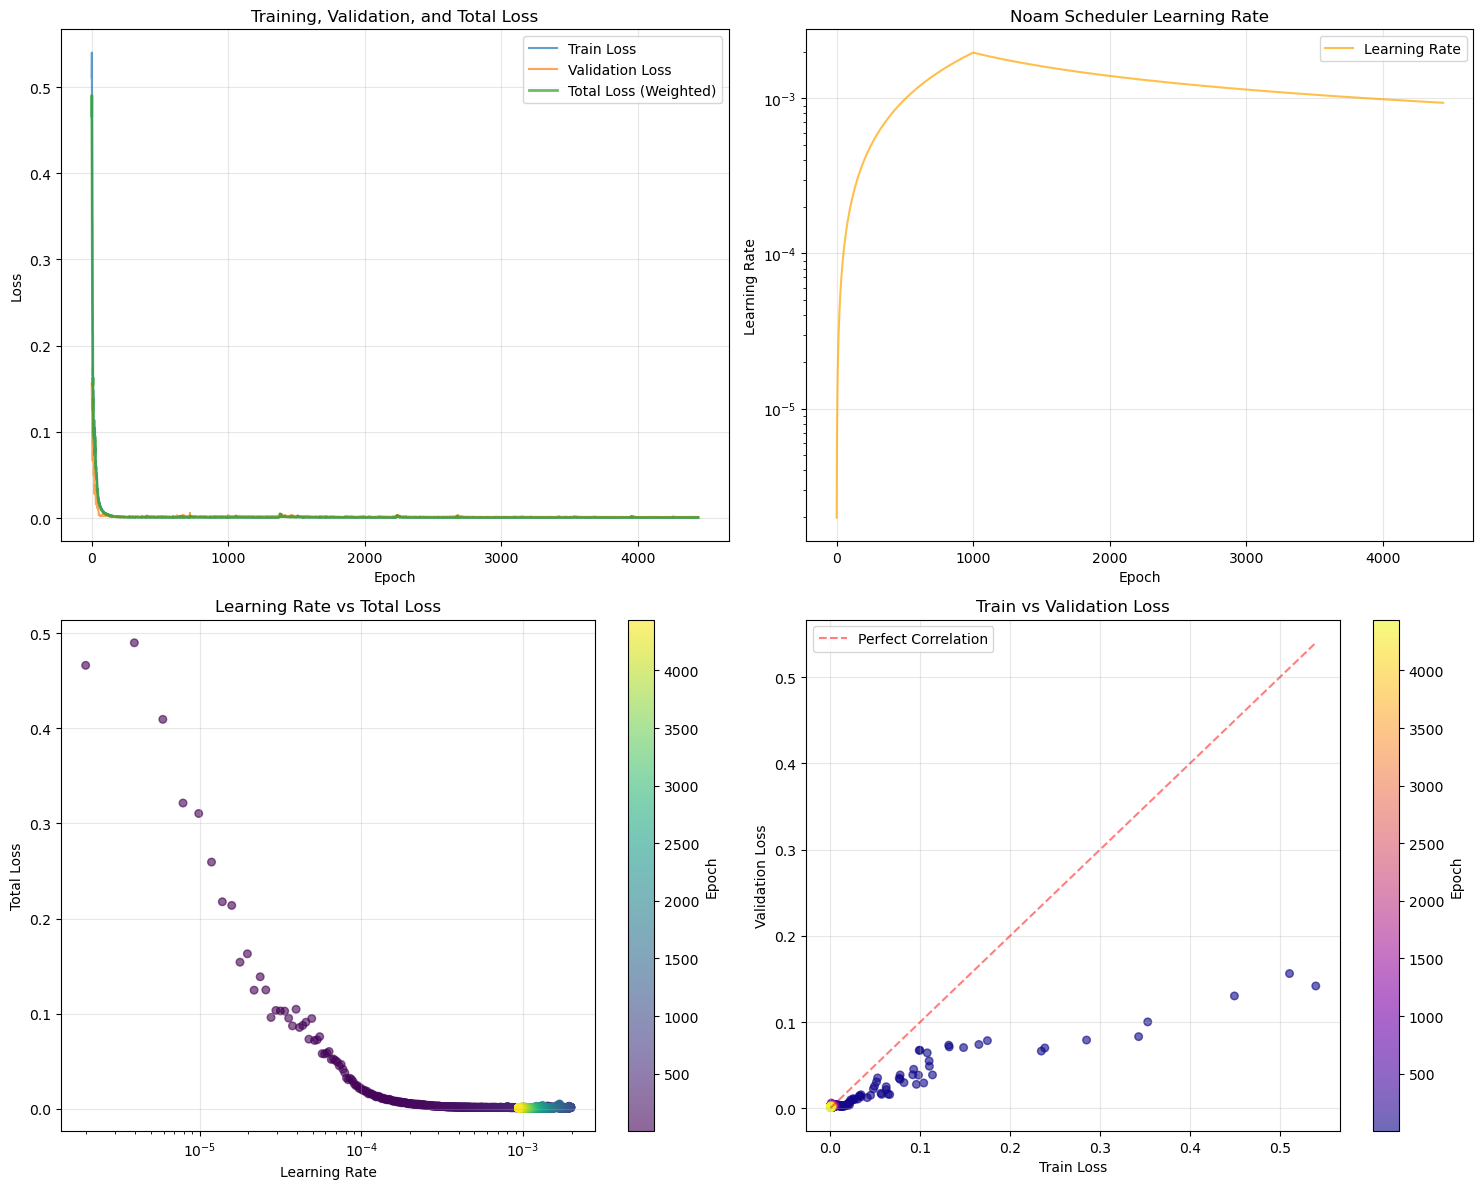


=== Training Statistics ===
Total epochs: 4442
Best total loss: 0.000752
Final train loss: 0.000696
Final validation loss: 0.001528
Final total loss: 0.000800
Initial learning rate: 1.98e-06
Final learning rate: 9.38e-04
Max learning rate: 1.98e-03
Min learning rate: 1.98e-06

=== Noam Scheduler Analysis ===
Model size (hidden_size): 256


AttributeError: 'NoamScheduler' object has no attribute 'warmup_steps'

In [34]:
# 학습 결과 시각화 - total_loss 포함
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. 손실 함수 변화 (train, val, total)
epochs = range(1, len(train_losses) + 1)
axes[0, 0].plot(epochs, train_losses, label='Train Loss', alpha=0.7)
axes[0, 0].plot(epochs, val_losses, label='Validation Loss', alpha=0.7)
axes[0, 0].plot(epochs, total_losses, label='Total Loss (Weighted)', alpha=0.7, linewidth=2)
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Training, Validation, and Total Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. 학습률 변화 (Noam scheduler)
axes[0, 1].plot(epochs, learning_rates, label='Learning Rate', color='orange', alpha=0.7)
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Learning Rate')
axes[0, 1].set_title('Noam Scheduler Learning Rate')
axes[0, 1].set_yscale('log')  # 로그 스케일로 표시
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. 학습률과 Total 손실의 관계
scatter = axes[1, 0].scatter(learning_rates, total_losses, alpha=0.6, c=epochs, cmap='viridis', s=30)
axes[1, 0].set_xlabel('Learning Rate')
axes[1, 0].set_ylabel('Total Loss')
axes[1, 0].set_title('Learning Rate vs Total Loss')
axes[1, 0].set_xscale('log')
axes[1, 0].grid(True, alpha=0.3)
cbar1 = plt.colorbar(scatter, ax=axes[1, 0])
cbar1.set_label('Epoch')

# 4. Train vs Validation Loss 산점도
scatter2 = axes[1, 1].scatter(train_losses, val_losses, alpha=0.6, c=epochs, cmap='plasma', s=30)
axes[1, 1].set_xlabel('Train Loss')
axes[1, 1].set_ylabel('Validation Loss')
axes[1, 1].set_title('Train vs Validation Loss')
axes[1, 1].grid(True, alpha=0.3)
# 대각선 추가 (perfect correlation)
min_loss = min(min(train_losses), min(val_losses))
max_loss = max(max(train_losses), max(val_losses))
axes[1, 1].plot([min_loss, max_loss], [min_loss, max_loss], 'r--', alpha=0.5, label='Perfect Correlation')
axes[1, 1].legend()
cbar2 = plt.colorbar(scatter2, ax=axes[1, 1])
cbar2.set_label('Epoch')

plt.tight_layout()
plt.show()

# 학습 통계 출력
print("\n=== Training Statistics ===")
print(f"Total epochs: {len(train_losses)}")
print(f"Best total loss: {best_total_loss:.6f}")
print(f"Final train loss: {train_losses[-1]:.6f}")
print(f"Final validation loss: {val_losses[-1]:.6f}")
print(f"Final total loss: {total_losses[-1]:.6f}")
print(f"Initial learning rate: {learning_rates[0]:.2e}")
print(f"Final learning rate: {learning_rates[-1]:.2e}")
print(f"Max learning rate: {max(learning_rates):.2e}")
print(f"Min learning rate: {min(learning_rates):.2e}")

# Noam scheduler 특성 분석
print(f"\n=== Noam Scheduler Analysis ===")
print(f"Model size (hidden_size): {scheduler.model_size}")
print(f"Warmup steps: {scheduler.warmup_steps}")
print(f"Factor: {scheduler.factor}")
warmup_lr = scheduler.factor * (scheduler.model_size ** (-0.5) * scheduler.warmup_steps ** (-0.5))
print(f"Peak learning rate at warmup: {warmup_lr:.2e}")

# 데이터 분포 가중치 정보
print(f"\n=== Data Distribution Weights ===")
print(f"Train samples: {train_samples} (weight: {train_weight:.3f})")
print(f"Validation samples: {val_samples} (weight: {val_weight:.3f})")
print(f"Total loss formula: {train_weight:.3f} * train_loss + {val_weight:.3f} * val_loss")

# 최고 성능 에포크 찾기
best_epoch = total_losses.index(min(total_losses)) + 1
print(f"\n=== Best Performance ===")
print(f"Best epoch: {best_epoch}")
print(f"Best total loss: {min(total_losses):.6f}")
print(f"Train loss at best epoch: {train_losses[best_epoch-1]:.6f}")
print(f"Val loss at best epoch: {val_losses[best_epoch-1]:.6f}")
print(f"Learning rate at best epoch: {learning_rates[best_epoch-1]:.2e}")

# 모델 저장 정보
print(f"\n=== Model Saved ===")
print(f"Best model saved as: best_bmed_noam_model.pth")
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")